In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333: #and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [02:39<00:00, 66.33it/s]


10556

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10556, (174625,))

In [3]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
# Standardize the recordings (not used in this example)
# standard = StandardScaler()
# adjusted_recordings = standard.fit_transform(adjusted_recordings)
#print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

### Padding with zeros
# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(adjusted_recordings, valence_values, test_size=0.2, random_state=42)


############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



############################################################################################################
# Validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211445\AppData\Local\Temp\ipykernel_10692\3858996454.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([8444, 1, 174625]), torch.Size([8444]))

In [6]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

models = {}


class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, dilation=2):
        super(ResidualBlock, self).__init__()


        padding = (kernel_size - 1) * dilation // 2  

        # 1st Convolutional Layer
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

        # 2nd Convolutional Layer
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        #  addition of input to the output -- residual connection
        out += residual  
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=8000,      ## 
            n_mfcc=24              ## Created channels
        )


        self.layers = nn.ModuleList()
        
        # Start with 1D BatchNorm
        self.layers.append(nn.BatchNorm1d(24))


        ###########################
        # 1st Convolutional Layer
        ###########################

        conv1 = nn.Conv1d(in_channels=24, out_channels=64, kernel_size=7, padding=1)
        # Initialize the weight using He initialization
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(64))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.3))

        ###########################
        # Residual Block
        ###########################
        self.layers.append(ResidualBlock(64))

        ###########################
        # 2nd Convolutional Layer
        ###########################
        
        conv2 = nn.Conv1d(in_channels=64, out_channels=48, kernel_size=7, padding=1)
        # He initialization
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())

        ###########################
        # 3rd Convolutional Layer
        ###########################

        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1,dilation=2)
        # He initialization
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        ###########################
        # Flatten
        ###########################
        self.layers.append(nn.Flatten())

        ###########################
        # 1st Fully Connected Layer
        ###########################

        linear1= nn.Linear(1104,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        ###########################
        # 2nd Fully Connected Layer
        ###########################
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)




    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs,save_dir = 'model_checkpoint/'):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        criterion = nn.MSELoss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            MLP_model.train()
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # To GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass
                optimizer.step()
                total_loss += loss.item()
            
            # Print the loss every epoch
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                # Set the model to evaluation mode and calculate the loss for the validation set
                MLP_model.eval() 
                val_eval = evaluate_model(MLP_model, validation_loader,conf=False)
                print(f'Validation: {val_eval}')
                # Set the model back to training mode
                MLP_model.train()
            print('--------------------------------------------------')

            # Save the model at each epoch using torch.save
            torch.save({
                'epoch': epoch,
                'model_state_dict': MLP_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
                    
        print(evaluate_model(MLP_model, train_loader,conf=True))



def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():

        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        #print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
        return f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}'



############################################################################################################
### PREDICT
def predict(model, data, device):
    model.eval()  
    data = data.to(device)  
    with torch.no_grad(): 
        predictions = []
        for sample in data:
            sample = sample.unsqueeze(0)  
            output = model(sample)
            predictions.append(output.item())
    return predictions





            
        

        


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Loss: 12.1455
--------------------------------------------------


  7%|▋         | 2/30 [00:49<10:04, 21.60s/it]

Epoch [2/30], Loss: 5.9877
--------------------------------------------------
Epoch [3/30], Loss: 4.8918


 10%|█         | 3/30 [00:58<07:11, 15.97s/it]

Validation: Mean Squared Error: 3.7010 and Mean Absolute Error: 1.6777
--------------------------------------------------
Epoch [4/30], Loss: 2.7453


 13%|█▎        | 4/30 [01:06<05:35, 12.90s/it]

Validation: Mean Squared Error: 7.7166 and Mean Absolute Error: 1.9897
--------------------------------------------------
Epoch [5/30], Loss: 2.6666


 17%|█▋        | 5/30 [01:14<04:39, 11.19s/it]

Validation: Mean Squared Error: 3.9466 and Mean Absolute Error: 1.8009
--------------------------------------------------
Epoch [6/30], Loss: 6.8727


 20%|██        | 6/30 [01:22<04:03, 10.15s/it]

Validation: Mean Squared Error: 8.4262 and Mean Absolute Error: 2.7848
--------------------------------------------------
Epoch [7/30], Loss: 8.4501


 23%|██▎       | 7/30 [01:30<03:38,  9.50s/it]

Validation: Mean Squared Error: 8.2247 and Mean Absolute Error: 2.7476
--------------------------------------------------
Epoch [8/30], Loss: 7.7050


 27%|██▋       | 8/30 [01:39<03:19,  9.09s/it]

Validation: Mean Squared Error: 6.8616 and Mean Absolute Error: 2.4839
--------------------------------------------------
Epoch [9/30], Loss: 4.9779


 30%|███       | 9/30 [01:47<03:05,  8.83s/it]

Validation: Mean Squared Error: 2.7695 and Mean Absolute Error: 1.3447
--------------------------------------------------
Epoch [10/30], Loss: 4.7556


 33%|███▎      | 10/30 [01:55<02:53,  8.67s/it]

Validation: Mean Squared Error: 9.3613 and Mean Absolute Error: 2.6451
--------------------------------------------------
Epoch [11/30], Loss: 4.7528


 37%|███▋      | 11/30 [02:04<02:43,  8.59s/it]

Validation: Mean Squared Error: 2.2340 and Mean Absolute Error: 1.2350
--------------------------------------------------
Epoch [12/30], Loss: 4.9669


 40%|████      | 12/30 [02:12<02:34,  8.57s/it]

Validation: Mean Squared Error: 5.8314 and Mean Absolute Error: 2.2692
--------------------------------------------------
Epoch [13/30], Loss: 5.5489


 43%|████▎     | 13/30 [02:21<02:24,  8.51s/it]

Validation: Mean Squared Error: 4.9285 and Mean Absolute Error: 2.0580
--------------------------------------------------
Epoch [14/30], Loss: 4.4975


 47%|████▋     | 14/30 [02:29<02:16,  8.50s/it]

Validation: Mean Squared Error: 4.5213 and Mean Absolute Error: 1.8693
--------------------------------------------------
Epoch [15/30], Loss: 4.0707


 50%|█████     | 15/30 [02:37<02:07,  8.47s/it]

Validation: Mean Squared Error: 3.2655 and Mean Absolute Error: 1.5785
--------------------------------------------------
Epoch [16/30], Loss: 2.6505


 53%|█████▎    | 16/30 [02:46<01:58,  8.48s/it]

Validation: Mean Squared Error: 2.1235 and Mean Absolute Error: 1.2554
--------------------------------------------------
Epoch [17/30], Loss: 1.5383


 57%|█████▋    | 17/30 [02:54<01:50,  8.48s/it]

Validation: Mean Squared Error: 0.8900 and Mean Absolute Error: 0.7750
--------------------------------------------------
Epoch [18/30], Loss: 0.7661


 60%|██████    | 18/30 [03:03<01:41,  8.43s/it]

Validation: Mean Squared Error: 0.8832 and Mean Absolute Error: 0.7488
--------------------------------------------------
Epoch [19/30], Loss: 1.2944


 63%|██████▎   | 19/30 [03:11<01:32,  8.40s/it]

Validation: Mean Squared Error: 1.6792 and Mean Absolute Error: 1.0732
--------------------------------------------------
Epoch [20/30], Loss: 1.6237


 67%|██████▋   | 20/30 [03:19<01:23,  8.37s/it]

Validation: Mean Squared Error: 1.4450 and Mean Absolute Error: 0.9809
--------------------------------------------------
Epoch [21/30], Loss: 1.1975


 70%|███████   | 21/30 [03:28<01:15,  8.35s/it]

Validation: Mean Squared Error: 0.9813 and Mean Absolute Error: 0.7936
--------------------------------------------------
Epoch [22/30], Loss: 0.8537


 73%|███████▎  | 22/30 [03:36<01:06,  8.36s/it]

Validation: Mean Squared Error: 0.7513 and Mean Absolute Error: 0.6968
--------------------------------------------------
Epoch [23/30], Loss: 0.7198


 77%|███████▋  | 23/30 [03:44<00:58,  8.35s/it]

Validation: Mean Squared Error: 0.6783 and Mean Absolute Error: 0.6708
--------------------------------------------------
Epoch [24/30], Loss: 0.6925


 80%|████████  | 24/30 [03:53<00:50,  8.35s/it]

Validation: Mean Squared Error: 0.7002 and Mean Absolute Error: 0.6802
--------------------------------------------------
Epoch [25/30], Loss: 0.7496


 83%|████████▎ | 25/30 [04:01<00:41,  8.35s/it]

Validation: Mean Squared Error: 0.8524 and Mean Absolute Error: 0.7235
--------------------------------------------------
Epoch [26/30], Loss: 0.9028


 87%|████████▋ | 26/30 [04:09<00:33,  8.35s/it]

Validation: Mean Squared Error: 1.1014 and Mean Absolute Error: 0.7645
--------------------------------------------------
Epoch [27/30], Loss: 1.0696


 90%|█████████ | 27/30 [04:18<00:25,  8.36s/it]

Validation: Mean Squared Error: 1.2115 and Mean Absolute Error: 0.7805
--------------------------------------------------
Epoch [28/30], Loss: 1.5641


 93%|█████████▎| 28/30 [04:26<00:16,  8.35s/it]

Validation: Mean Squared Error: 4.0502 and Mean Absolute Error: 0.8646
--------------------------------------------------
Epoch [29/30], Loss: 1.5062


 97%|█████████▋| 29/30 [04:35<00:08,  8.37s/it]

Validation: Mean Squared Error: 1.7611 and Mean Absolute Error: 0.8137
--------------------------------------------------
Epoch [30/30], Loss: 1.4393


100%|██████████| 30/30 [04:43<00:00,  9.45s/it]

Validation: Mean Squared Error: 1.7071 and Mean Absolute Error: 0.8021
--------------------------------------------------


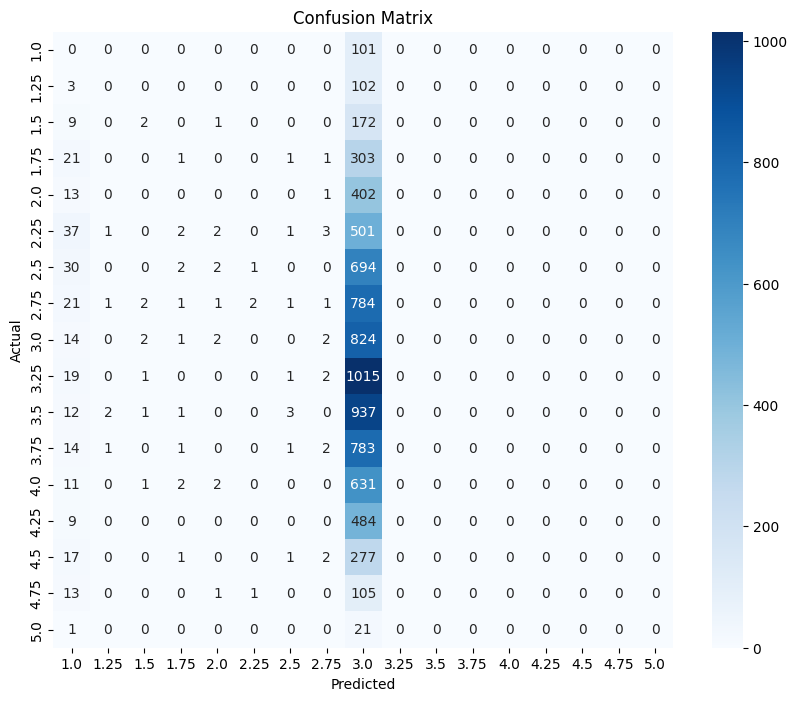

Accuracy: 0.0981
Mean Squared Error: 1.3565 and Mean Absolute Error: 0.7832


In [7]:
modelCNN = CNN().to(device)
#optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)

train_model(modelCNN, optimizer, num_epochs=30)